<a href="https://colab.research.google.com/github/accarter/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/Swimmingly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Swimmingly

This notebook was used to create a web application that can be found at https://swimmingly-app.herokuapp.com/.

**An important note:**

This notebook explores a particular use case for a web application, which is to use times that a swimmer has for a number of events to predict what that same swimmer's time would be in another event.  In this notebook, we explore the case where the user has supplied times for the 50 and 100 yard free, 50 meter free, and 100 yard back, breast, and fly.  We use these times to predict what time that swimmer would have in the 100 meter free.  The application derived from this notebook, however, attempts to predict the time for any event using any possible non-zero combination of events.

## Preprocessing

In [ ]:
!pip install pdpbox
!pip install eli5
!pip install shap

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/accarter/time-predictor/master/top_times.csv"
top_times = pd.read_csv(url, sep="\t")

## Data Wrangling

In [ ]:
def time_to_ms(row):
    time = row["swim_time_formatted"].strip("r")
    minutes = 0
    if ":" in time:
        minutes, time = time.split(":")
    seconds, hundredths = time.split(".")
    return int(minutes) * 60 * 1000 + int(seconds) * 1000 + int(hundredths) * 10

def wrangle(X):
    X = X.copy()

    # use unique names only
    X = X.drop_duplicates(subset=["full_name", "event_desc"])
    X = X[~X["swim_time_formatted"].str.contains('CM')]

    # convert time string to milliseconds
    X["swim_time_formatted"] = X.apply(time_to_ms, axis=1)

    # format DataFrame such that each swimmer is a row
    X = pd.pivot_table(
        X,
        index=["full_name"],
        columns="event_desc",
        values="swim_time_formatted"
    ).reset_index()

    return X

individual_results = wrangle(top_times)
individual_results.shape

(76728, 54)

## Baseline Score

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


target = '100 FR LCM'
features = ['100 FR SCY', '50 FR LCM', '100 BK SCY', '100 BR SCY', '100 FL SCY']


def mask_for_events(df, *args):
    mask = np.array([True] * df.shape[0])
    for arg in args:
        mask = mask & ~np.isnan(df[arg])
    return mask
    

def get_selection(target, events, df):
  mask = mask_for_events(individual_results, target, *events)
  return individual_results[mask][events + [target]]


selection = get_selection(target, features, individual_results)
train, val = train_test_split(selection)
X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]

pred = [y_train.mean()] * len(y_train)
print('MAE:', mean_absolute_error(y_train, pred))
print('Mean Squared Error: ', mean_squared_error(y_train, pred))
print('R2:', r2_score(y_train, pred))

MAE: 1210.2592592592596
Mean Squared Error:  2286910.527777778
R2: 0.0


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

def predict(target, events, X_train, y_train, X_val):
  reg = LinearRegression().fit(X_train, y_train)
  return reg.predict(X_val)

pred = predict(target, features, X_train, y_train, X_val)
print('MAE:', mean_absolute_error(y_val, pred))
print('Mean Squared Error: ', mean_squared_error(y_val, pred))
print('R2:', r2_score(y_val, pred))

MAE: 688.9421986489401
Mean Squared Error:  697527.3863998493
R2: 0.6908352122801225


### Visualizations for Linear Regression

Comparing the actual times with the predicted times using a scatter plot offers a visual representation of which features are weighted more heavily when making a prediction.  That is, as the coordinates more closely conform to a linear relationship for a particular feature, the more influence that feature has on the equation used to represent the model.

In [ ]:
import plotly.graph_objects as go


def plot(event):
  fig = go.Figure()
  
  x = X_val[event]

  fig.add_trace(go.Scatter(
        x=x, 
        y=y_val,
        mode='markers',
        name=event
        ))

  fig.add_trace(go.Scatter(
        x=x, 
        y=pred,
        mode='markers',
        name='Predictions'
        ))

  fig.show()

for event in features:
  plot(event) 

### Partial Dependency Plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


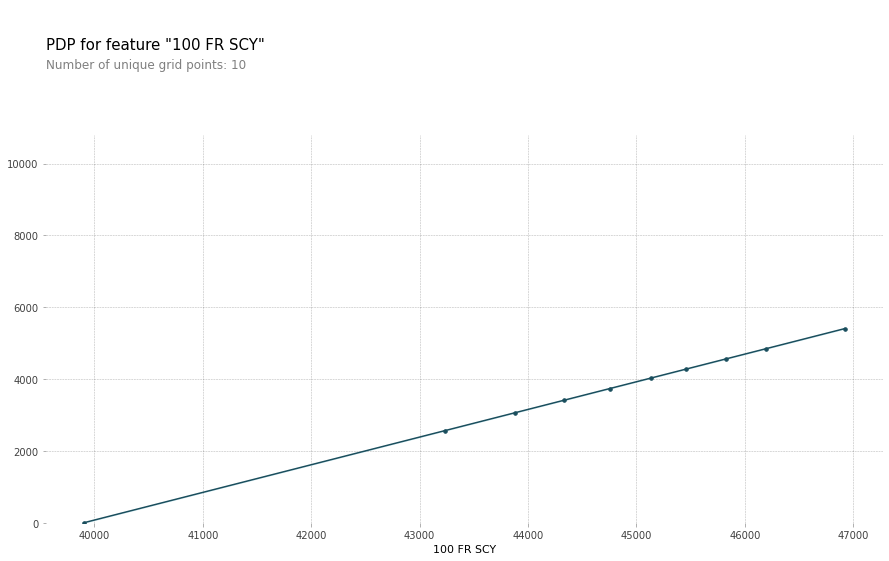

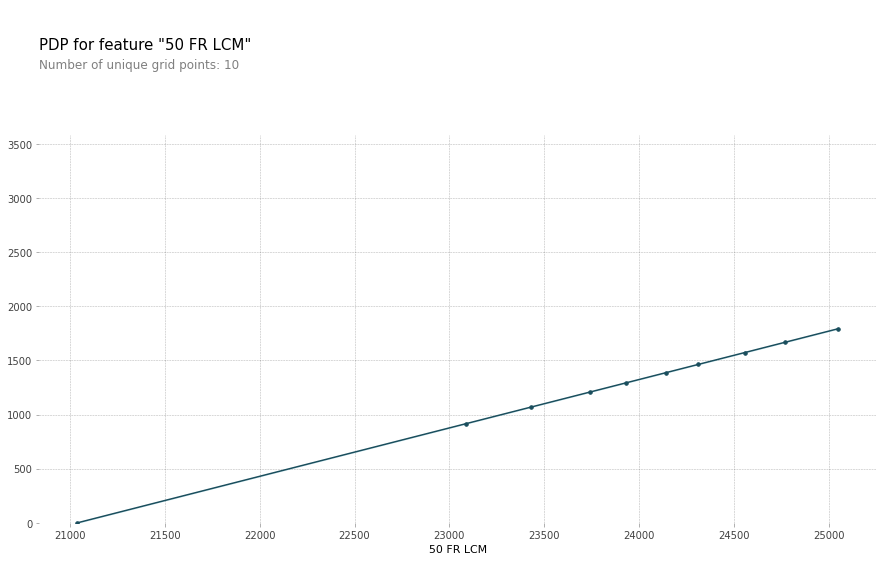

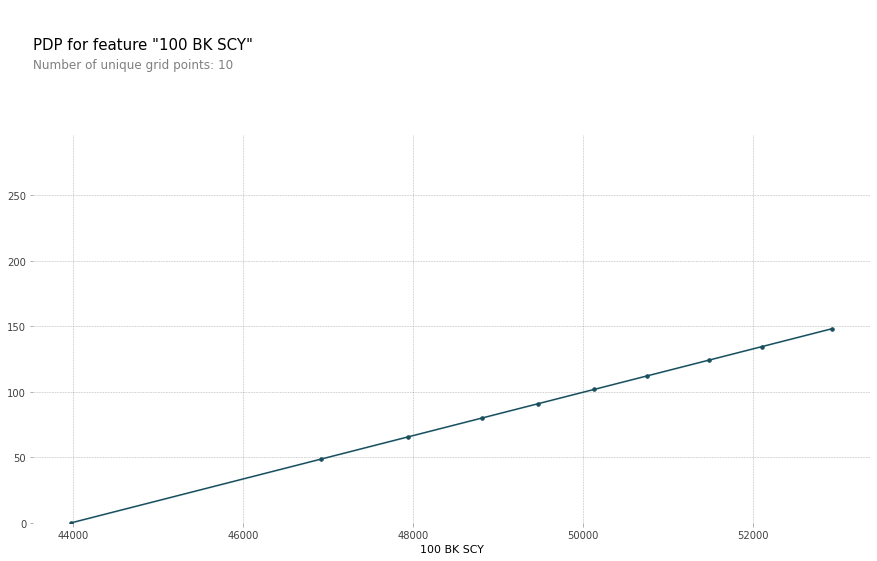

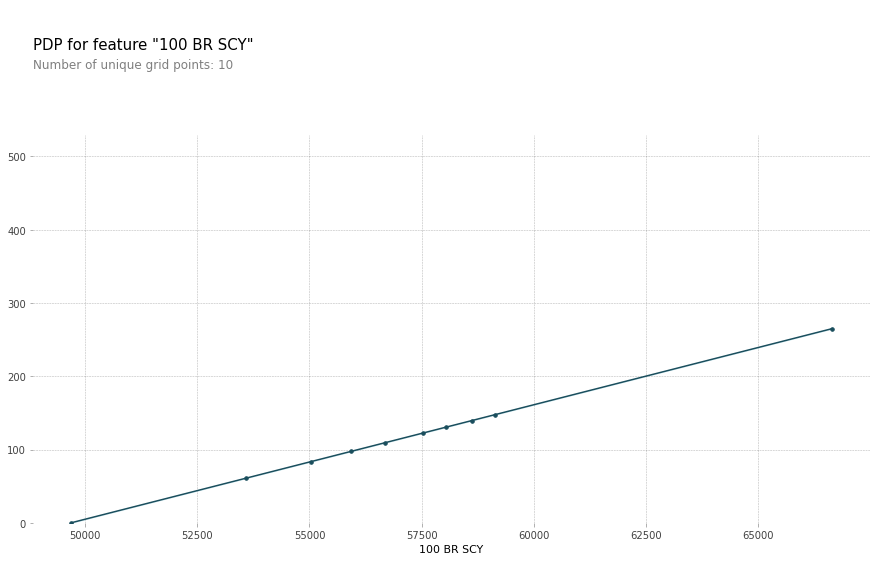

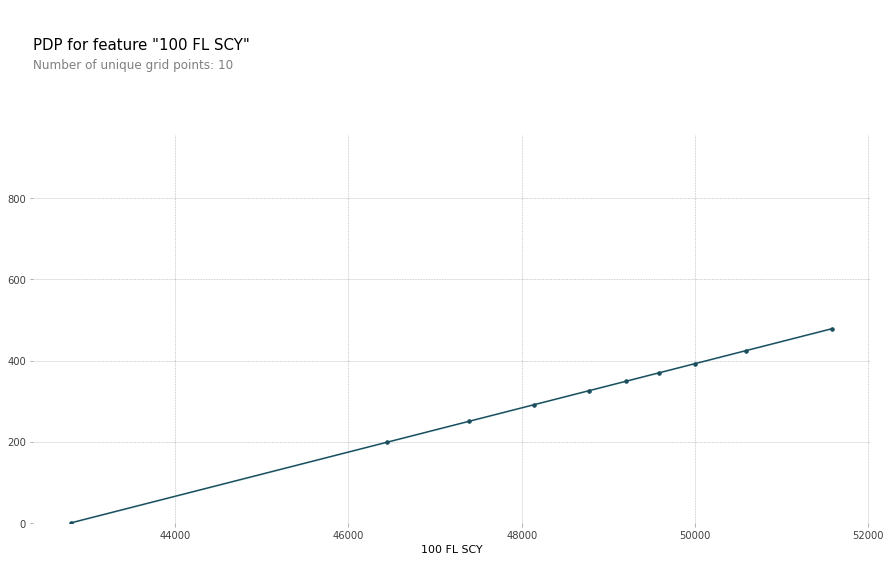

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

def plot_pdp(feature):
  isolated = pdp_isolate(
      model=LinearRegression().fit(selection[features], selection[target]),
      dataset=selection,
      model_features=selection.columns[:-1],
      feature=feature)

  pdp_plot(isolated, feature_name=feature);

for feature in features:
  plot_pdp(feature)

### Permutation Importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

model = LinearRegression()
model.fit(X_train, y_train)

permuter = PermutationImportance(
    model,
    n_iter=5,
    random_state=42 
)

permuter.fit(X_val, y_val)
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=features
)

Weight,Feature
0.7519 ± 0.1598,100 FR SCY
0.0821 ± 0.0290,50 FR LCM
0.0113 ± 0.0112,100 FL SCY
0.0018 ± 0.0019,100 BK SCY
0.0015 ± 0.0023,100 BR SCY


## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def predict(target, events, X_train, y_train, X_val):
  reg = RandomForestRegressor().fit(X_train, y_train)
  return reg.predict(X_val)

pred = predict(target, features, X_train, y_train, X_val)
print('MAE:', mean_absolute_error(y_val, pred))
print('Mean Squared Error: ', mean_squared_error(y_val, pred))
print('R2:', r2_score(y_val, pred))

MAE: 757.4280991735536
Mean Squared Error:  881000.7335537191
R2: 0.6095143931537956


### Shapley values for Random Forest Regressor

In [ ]:
import shap

model = RandomForestRegressor()
model.fit(X_train, y_train)

# Calculate shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val.iloc[0])

# Get series with shap values, feature names, & feature values
feature_names = X_val.columns
feature_values = X_val.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

# Print results
print(shaps.to_string())

# Show shapley values force plot
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=features
)

(100 FR SCY, 46870.0)    1575.667205
(50 FR LCM, 23850.0)     1575.667205
(100 BK SCY, 48850.0)    1575.667205
(100 BR SCY, 58910.0)    1575.667205
(100 FL SCY, 49500.0)    1575.667205
